In [1]:
import numpy as np
import pandas as pd
import os, warnings
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
DATA_FOLDER_PATH = '/Users/prakashadhikari******************/B0'# path folder for data
mapper_df = pd.read_csv(os.path.join(DATA_FOLDER_PATH, 'mapper_df.csv'))
mapper_df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']


L_MAX = 3

def construct_pi_basis_and_compute_glm_coefficients(df, l_max=L_MAX):
    """
    Constructs harmonic polynomial pi basis  for Bx, By, and Bz up to degree l_max, finds the Glm coeff
    minimizing Bx, By and Bz simultaneouly using lstsq (np.linsalg)
    
    Parameters: 
        df :pd.DataFrame of columns ['x', 'y', 'z', 'Bx', 'By', 'Bz'] in cylindrical coordinates.
        l_max : int, takes 0-3; for values > 3,  function will take default l_max=3,raising UserWarning.

    Returns:
        basis_df(symbols only) : pd.DataFrame of columns ['l', 'm', 'pi_x', 'pi_y', 'pi_z'], basis function for Bx, By, Bz
        glm_coeff_df: pd.DataFrame of columns ['l', 'm', G_lm]
        combined_basis_matrix: bais of Bx, By and Bz 
    Notes: g_lm coeff with magnitude <1e-6 are set to 0
         : for using Glm coeff to reconstruct must be used combined_basis_matrix
    """

    if l_max > 3:
        warnings.warn(" ***This functions only supports to l=3, so takes l=3 as default  ***",UserWarning)
       
        l_max=3

    x, y, z, Bx, By, Bz = [df[col_name].to_numpy() for col_name in df.columns]

    def harmonic_basis_Bx(x, y, z, l_max):
        l_list, m_list, label_list, basis_list = [], [], [], []
        for l in range(l_max + 1):
            m = np.arange(-l - 1, l + 2)
            l_list += [l] * len(m)
            m_list += list(m)
            if l == 0:
                basis_list += [0*x, 0*x, 1 + 0*x]
                label_list += ['0', '0', '1']
            elif l == 1:
                basis_list += [y, 0*y, -0.5*x, z, x]
                label_list += ['y', '0', '-1/2 x', 'z', 'x']
            elif l == 2:
                basis_list += [2*x*y, 2*y*z, -0.5*x*y, -x*z,
                               -0.25*(3*x**2 + y**2 - 4*z**2), 2*x*z, x**2 - y**2]
                label_list += ['2xy', '2yz', '-1/2 xy', '-xz',
                               '-1/4(3x²+y²−4z²)', '2xz', 'x²−y²']
            else:
                basis_list += [3*x**2*y - y**3, 6*x*y*z,
                               -0.5*(3*x**2*y + y**3 - 6*y*z**2), -1.5*x*y*z,
                               (3/8)*(x**3 + x*y**2 - 4*x*z**2),
                               -0.25*(9*x**2*z + 3*y**2*z - 4*z**3),
                               -x**3 + 3*x*z**2, 3*(x**2*z - y**2*z), x**3 - 3*x*y**2]
                label_list += ['3x²y−y³', '6xyz', '-1/2(3x²y+y³−6yz²)', '-3/2 xyz',
                               '3/8(x³+xy²−4xz²)', '-1/4(9x²z+3y²z−4z³)',
                               '-x³+3xz²', '3(x²z−y²z)', 'x³−3xy²']
        return l_list, m_list, label_list, basis_list

    def harmonic_basis_By(x, y, z, l_max):
        l_list, m_list, label_list, basis_list = [], [], [], []
        for l in range(l_max + 1):
            m = np.arange(-l - 1, l + 2)
            l_list += [l] * len(m)
            m_list += list(m)
            if l == 0:
                basis_list += [1 + 0*y, 0*y, 0*y]
                label_list += ['1', '0', '0']
            elif l == 1:
                basis_list += [x, z, -0.5*y, 0*y, -y]
                label_list += ['x', 'z', '-1/2 y', '0', '-y']
            elif l == 2:
                basis_list += [x**2 - y**2, 2*x*z, -0.25*(x**2 + 3*y**2 - 4*z**2),
                               -y*z, -0.5*x*y, -2*y*z, -2*x*y]
                label_list += ['x²−y²', '2xz', '-1/4(x²+3y²−4z²)', '-yz',
                               '-1/2 xy', '-2yz', '-2xy']
            else:
                basis_list += [x**3 - 3*x*y**2, 3*(x**2*z - y**2*z),
                               -0.5*(x**3 + 3*y**2*x - 6*x*z**2),
                               -0.25*(3*x**2*z + 9*y**2*z - 4*z**3),
                               (3/8)*(x**2*y + y**3 - 4*y*z**2), -1.5*x*y*z,
                               -3*y*z**2 + y**3, -6*x*y*z, -3*x**2*y + y**3]
                label_list += ['x³−3xy²', '3(x²z−y²z)', '-1/2(x³+3y²x−6xz²)',
                               '-1/4(3x²z+9y²z−4z³)', '3/8(x²y+y³−4yz²)',
                               '-3/2 xyz', '-3yz²+y³', '-6xyz', '-3x²y+y³']
        return l_list, m_list, label_list, basis_list

    def harmonic_basis_Bz(x, y, z, l_max):
        l_list, m_list, label_list, basis_list = [], [], [], []
        for l in range(l_max + 1):
            m = np.arange(-l - 1, l + 2)
            l_list += [l] * len(m)
            m_list += list(m)
            if l == 0:
                basis_list += [0*z, 1 + 0*z, 0*z]
                label_list += ['0', '1', '0']
            elif l == 1:
                basis_list += [0*z, y, z, x, 0*z]
                label_list += ['0', 'y', 'z', 'x', '0']
            elif l == 2:
                basis_list += [0*z, 2*x*y, 2*y*z, z**2 - 0.5*(x**2 + y**2),
                               2*x*z, x**2 - y**2, 0*z]
                label_list += ['0', '2xy', '2yz', 'z²−1/2(x²+y²)', '2xz', 'x²−y²', '0']
            else:
                basis_list += [0*z, 3*x**2*y - y**3, 6*x*y*z,
                               3*y*z**2 - (3/4)*(x**2*y + y**3),
                               z**3 - (3/2)*z*(x**2 + y**2),
                               3*x*z**2 - (3/4)*(x**3 + x*y**2),
                               3*(x**2*z - y**2*z), x**3 - 3*x*y**2, 0*z]
                label_list += ['0', '3x²y−y³', '6xyz',
                               '3yz²−¾(x²y+y³)', 'z³−³⁄₂z(x²+y²)',
                               '3xz²−¾(x³+xy²)', '3(x²z−y²z)', 'x³−3xy²', '0']
        return l_list, m_list, label_list, basis_list

    l_list, m_list, label_bx, basis_bx = harmonic_basis_Bx(x, y, z, l_max)
    _, _, label_by, basis_by = harmonic_basis_By(x, y, z, l_max)
    _, _, label_bz, basis_bz = harmonic_basis_Bz(x, y, z, l_max)

    basis_df = pd.DataFrame({
        'l': l_list,
        'm': m_list,
        'pi_x': label_bx,
        'pi_y': label_by,
        'pi_z': label_bz})
    
    
    basis_matrix_Bx= np.column_stack(basis_bx)
    basis_matrix_By= np.column_stack(basis_by)
    basis_matrix_Bz= np.column_stack(basis_bz)
    combined_basis_matrix= np.vstack((basis_matrix_Bx, basis_matrix_By, basis_matrix_Bz))
    combined_B_fields= np.concatenate([Bx, By, Bz])
    glm_coeff= lstsq(combined_basis_matrix,combined_B_fields, rcond= None)[0]
    glm_coeff[np.abs(glm_coeff)< 1e-6]= 0
    glm_coeff_df= pd.DataFrame({'l':l_list, 'm': m_list, 'g_lm':glm_coeff})
    

    return basis_df, glm_coeff_df, combined_basis_matrix
basis_df, glm_coeff_df, combined_basis_matrix = construct_pi_basis_and_compute_glm_coefficients(mapper_df, l_max=3)
basis_df
print('G lm coefficients \n', glm_coeff_df)


G lm coefficients 
     l  m         g_lm
0   0 -1     0.403067
1   0  0  1021.323633
2   0  1    -0.015010
3   1 -2    -0.085377
4   1 -1    -0.154663
5   1  0    -0.437646
6   1  1    -0.139128
7   1  2     0.470207
8   2 -3    -0.070148
9   2 -2     0.224100
10  2 -1    -0.091288
11  2  0     0.111858
12  2  1     0.158590
13  2  2     0.074932
14  2  3     0.037565
15  3 -4    -0.125376
16  3 -3     0.036784
17  3 -2    -0.007056
18  3 -1    -0.046634
19  3  0    -0.006494
20  3  1    -0.145083
21  3  2    -0.024197
22  3  3    -0.032473
23  3  4    -0.055625


In [2]:
print(basis_df)

    l  m                 pi_x                 pi_y            pi_z
0   0 -1                    0                    1               0
1   0  0                    0                    0               1
2   0  1                    1                    0               0
3   1 -2                    y                    x               0
4   1 -1                    0                    z               y
5   1  0               -1/2 x               -1/2 y               z
6   1  1                    z                    0               x
7   1  2                    x                   -y               0
8   2 -3                  2xy                x²−y²               0
9   2 -2                  2yz                  2xz             2xy
10  2 -1              -1/2 xy     -1/4(x²+3y²−4z²)             2yz
11  2  0                  -xz                  -yz   z²−1/2(x²+y²)
12  2  1     -1/4(3x²+y²−4z²)              -1/2 xy             2xz
13  2  2                  2xz                 -2yz           x

In [3]:
def reconstruct_field(df,combined_basis_matrix,glm_coeff_df):
    
    '''# reconstructing the same field using glm coeff
    #parameters: mapper_df of columns ['x', 'y','z'], bais matric and glm coeff df 
    #returns: reconststructed df of columns [x, y, z, Bx, By, Bz]
    '''
    x, y, z= [df[col] for col in ('x', 'y', 'z')]
    basis_Bx, basis_By, basis_Bz= np.split(combined_basis_matrix, 3)
    glm= glm_coeff_df['g_lm'].to_numpy()
    Bx_pred= basis_Bx@ glm
    By_pred= np.matmul(basis_By, glm)
    Bz_pred= np.matmul(basis_Bz, glm)
    df= pd.DataFrame({'x':x, 'y':y, 'z':z, 'Bx':Bx_pred,'By':By_pred, 'Bz':Bz_pred })
    return df
reconstructed_df= reconstruct_field(mapper_df, combined_basis_matrix,glm_coeff_df)
reconstructed_df

,x,y,z,Bx,By,Bz
0,-0.144338,-1.767500e-17,-0.15,-0.090818,0.445392,1021.420543
1,-0.135633,-4.936636e-02,-0.15,-0.077988,0.453170,1021.427736
2,-0.142145,-2.506396e-02,-0.15,-0.085810,0.449554,1021.424811
3,-0.125000,-7.216878e-02,-0.15,-0.067570,0.456207,1021.429145
4,-0.110569,-9.277840e-02,-0.15,-0.054842,0.458617,1021.428960
...,...,...,...,...,...,...
535,-0.160697,1.915111e-01,0.15,-0.150852,0.331047,1021.222775
536,-0.191511,1.606969e-01,0.15,-0.172115,0.339857,1021.233114
537,-0.234923,8.550504e-02,0.15,-0.200665,0.360436,1021.258580
538,-0.216506,1.250000e-01,0.15,-0.188884,0.349782,1021.245287


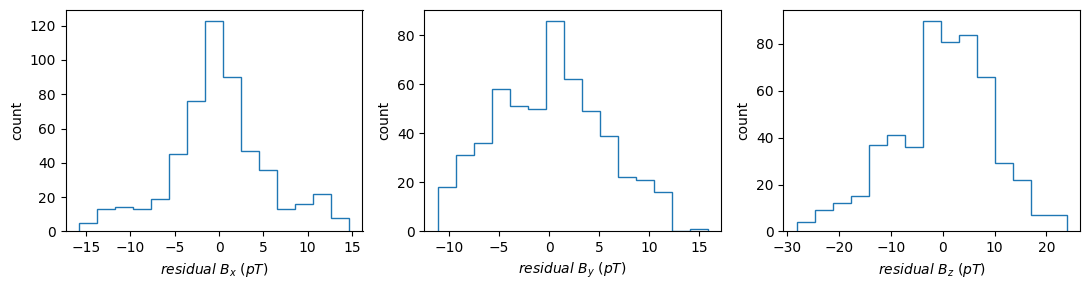

In [4]:
def plot_residual(mapper_df, reconstructed_df, bins=15):
    '''
    # plots the residual of fields between reconstructed and simulated field
    # retruns 3 subplot of residual
    # note: fields bx and By and nT and Bz in uT    '''
    
    fig= plt.figure(figsize=(11, 3))
    ax1, ax2, ax3= [fig.add_subplot(1,3,i) for i in (1,2,3)]
    ax1.hist((mapper_df['Bx']- reconstructed_df['Bx'])*1000, bins= bins, histtype ='step')
    ax2.hist((mapper_df['By']- reconstructed_df['By'])*1000,  bins= bins, histtype ='step')
    ax3.hist((mapper_df['Bz']- reconstructed_df['Bz'])*1000,  bins= bins, histtype ='step')
    [ax.set(ylabel= 'count' ,xlabel= f'$ residual$ $ B_{r}$ $(pT)$') for ax, r in zip((ax1, ax2, ax3) ,('x', 'y', 'z'))]
    plt.tight_layout()
plot_residual(mapper_df, reconstructed_df)